In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import dataset
from tqdm import tqdm

### Abstract
TODO

### Load Dataset

In [2]:
quickdraw_dataset = dataset.QuickDrawDataset(root="/data", download=False)

[quickdraw dataset: root=/data, download=False]


Split dataset into train, validation, and test. The split is 80/10/10.

In [7]:
train_set, val_set, test_set = dataset.split(quickdraw_dataset)
len(train_set), len(val_set), len(test_set)

(276000, 34500, 34500)

Create dataloaders for train, val, and test with a batch size of 128.

In [8]:
batch_size = 128

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

### Labels for Dataset

In [12]:
categories = dataset.QuickDrawDataset.categories()
num_categories = len(categories)
num_categories

345

### Visualize Dataset
See what different doodles look like.

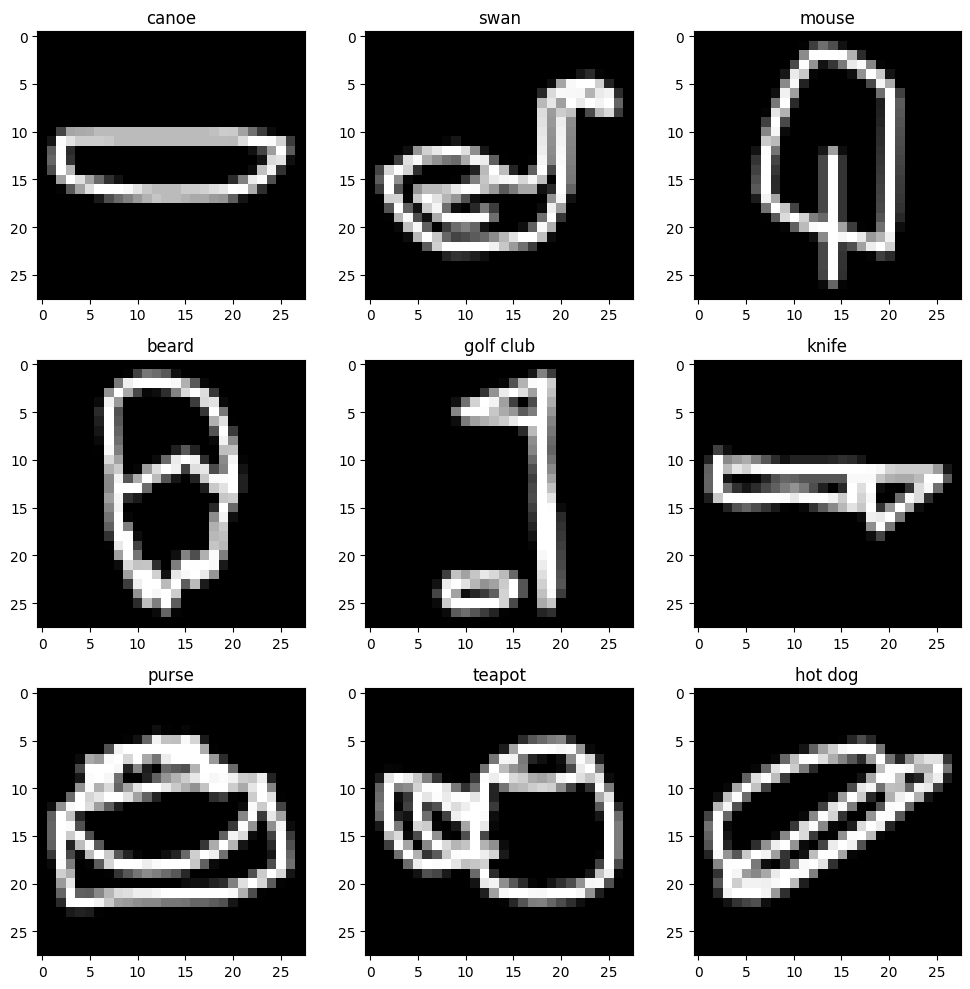

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
X, Y = test_set[:9]

for i, x in enumerate(X):
    y = Y[i]
    row, col = i // 3, i % 3
    
    # plot the image with its label
    category = categories[y]
    img = x[0]
    
    axes[row, col].imshow(img, cmap="gray")
    axes[row, col].set_title(category)
    
plt.tight_layout()

### Device
Use accelerated machine learning backend on Apple silicon if available

In [45]:
device = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

device

device(type='mps')

### Define Model
MiniAlexNet: TODO

In [72]:
class MiniAlexNet(nn.Module):
    def __init__(self, labels=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            nn.Conv2d(96, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.nn = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(6400, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, labels),
        )

        self.init_bias()

    def init_bias(self):
        # with torch.no_grad():
        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv[4].bias, 1)
        nn.init.constant_(self.conv[10].bias, 1)
        nn.init.constant_(self.conv[12].bias, 1)

    def forward(self, x):
        x = self.conv(x)

#         print(x.shape)
        x = x.reshape(x.size(0), -1)

        # print(x.shape)
        x = self.nn(x)

        return x

In [73]:
minialexnet = MiniAlexNet(labels=num_categories).to(device)
minialexnet

MiniAlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (nn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (

### Define Loss & Optimizer

In [74]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(minialexnet.parameters(), weight_decay=0.0005, momentum=0.9, lr=0.01)

### Train Model

In [75]:
num_train_batches = len(train_dataloader)
num_train_batches

2157

In [76]:
def evaluate(model, dataloader, criterion):
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss    

In [77]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs):
    train_losses = []
    val_losses = []
    
    print("Training")
    for epoch in range(epochs):
        # set mode to train
        model.train()
        
        total_loss = 0
        for i, (X, Y) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} of {epochs}", leave=True, position=0)):
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))
            total_loss += loss.item()
            
            # backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # average loss over batches
        train_loss = total_loss / len(train_dataloader)
        train_losses.append(train_loss)
        
        # evaluate model on validation set
        val_loss = evaluate(model, dataloader=val_dataloader, criterion=cross_entropy)
        val_losses.append(val_loss)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss}, Val Loss: {val_loss}")
        
    return train_losses, val_losses

In [81]:
EPOCHS = 30
MODEL = minialexnet
CRITERION = cross_entropy
OPTIMIZER = optimizer
TRAIN = train_dataloader
VALIDATION = val_dataloader

train_losses, val_losses = train(model=MODEL, 
                                 criterion=CRITERION, 
                                 optimizer=OPTIMIZER, 
                                 train_dataloader=TRAIN, 
                                 val_dataloader=VALIDATION, 
                                 epochs=EPOCHS)

Training


Epoch 1 of 30: 100%|████████████████████████| 2157/2157 [02:26<00:00, 14.73it/s]


Epoch [1/30], Loss: 2.481980218730373, Val Loss: 2.0935917015428895


Epoch 2 of 30: 100%|████████████████████████| 2157/2157 [02:29<00:00, 14.45it/s]


Epoch [2/30], Loss: 2.0470377097927868, Val Loss: 1.8082705881860521


Epoch 3 of 30: 100%|████████████████████████| 2157/2157 [02:25<00:00, 14.85it/s]


Epoch [3/30], Loss: 1.8361235745924736, Val Loss: 1.7244425274707653


Epoch 4 of 30: 100%|████████████████████████| 2157/2157 [02:27<00:00, 14.63it/s]


Epoch [4/30], Loss: 1.6987691942497045, Val Loss: 1.6733122384106671


Epoch 5 of 30: 100%|████████████████████████| 2157/2157 [02:26<00:00, 14.68it/s]


Epoch [5/30], Loss: 1.6004692276263601, Val Loss: 1.6283013842723988


Epoch 6 of 30: 100%|████████████████████████| 2157/2157 [02:24<00:00, 14.89it/s]


Epoch [6/30], Loss: 1.5222085050868943, Val Loss: 1.5934288205923857


Epoch 7 of 30: 100%|████████████████████████| 2157/2157 [02:28<00:00, 14.56it/s]


Epoch [7/30], Loss: 1.4569035271941704, Val Loss: 1.531575619291376


Epoch 8 of 30: 100%|████████████████████████| 2157/2157 [02:38<00:00, 13.57it/s]


Epoch [8/30], Loss: 1.404086123974057, Val Loss: 1.5327628625763787


Epoch 9 of 30: 100%|████████████████████████| 2157/2157 [02:24<00:00, 14.96it/s]


Epoch [9/30], Loss: 1.3555908291827323, Val Loss: 1.5558398048082986


Epoch 10 of 30: 100%|███████████████████████| 2157/2157 [02:24<00:00, 14.89it/s]


Epoch [10/30], Loss: 1.3117120188864282, Val Loss: 1.5399483508533902


Epoch 11 of 30: 100%|███████████████████████| 2157/2157 [02:34<00:00, 13.98it/s]


Epoch [11/30], Loss: 1.273928736474263, Val Loss: 1.5208860207487036


Epoch 12 of 30: 100%|███████████████████████| 2157/2157 [02:29<00:00, 14.38it/s]


Epoch [12/30], Loss: 1.2420218243718313, Val Loss: 1.5481389778631705


Epoch 13 of 30: 100%|███████████████████████| 2157/2157 [02:26<00:00, 14.71it/s]


Epoch [13/30], Loss: 1.2127608608801608, Val Loss: 1.49661643659627


Epoch 14 of 30: 100%|███████████████████████| 2157/2157 [02:40<00:00, 13.41it/s]


Epoch [14/30], Loss: 1.187218484140183, Val Loss: 1.5155155742609943


Epoch 15 of 30: 100%|███████████████████████| 2157/2157 [02:41<00:00, 13.38it/s]


Epoch [15/30], Loss: 1.1602790049783709, Val Loss: 1.5118344717555576


Epoch 16 of 30: 100%|███████████████████████| 2157/2157 [02:41<00:00, 13.36it/s]


Epoch [16/30], Loss: 1.1358558460137442, Val Loss: 1.514346228705512


Epoch 17 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 15.00it/s]


Epoch [17/30], Loss: 1.1102498709796256, Val Loss: 1.5232340490376508


Epoch 18 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [18/30], Loss: 1.0879940622981412, Val Loss: 1.5454324223377087


Epoch 19 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [19/30], Loss: 1.073147466020226, Val Loss: 1.53650440286707


Epoch 20 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [20/30], Loss: 1.0505824897042788, Val Loss: 1.5335589020340532


Epoch 21 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.98it/s]


Epoch [21/30], Loss: 1.0336375150572221, Val Loss: 1.5565485941039192


Epoch 22 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [22/30], Loss: 1.0164713593727468, Val Loss: 1.5582910932876446


Epoch 23 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [23/30], Loss: 0.9996781361617034, Val Loss: 1.547750985622406


Epoch 24 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [24/30], Loss: 0.9832338500089207, Val Loss: 1.5631137503517998


Epoch 25 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [25/30], Loss: 0.9693103549819773, Val Loss: 1.5893891882013391


Epoch 26 of 30: 100%|███████████████████████| 2157/2157 [02:40<00:00, 13.41it/s]


Epoch [26/30], Loss: 0.9555357165175231, Val Loss: 1.569751598879143


Epoch 27 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [27/30], Loss: 0.9427310312905133, Val Loss: 1.5875285802064119


Epoch 28 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [28/30], Loss: 0.9312224338797436, Val Loss: 1.5813761795008625


Epoch 29 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 15.00it/s]


Epoch [29/30], Loss: 0.9198052889365645, Val Loss: 1.6308466518366778


Epoch 30 of 30: 100%|███████████████████████| 2157/2157 [02:23<00:00, 14.99it/s]


Epoch [30/30], Loss: 0.9081056876817013, Val Loss: 1.5834220464582796


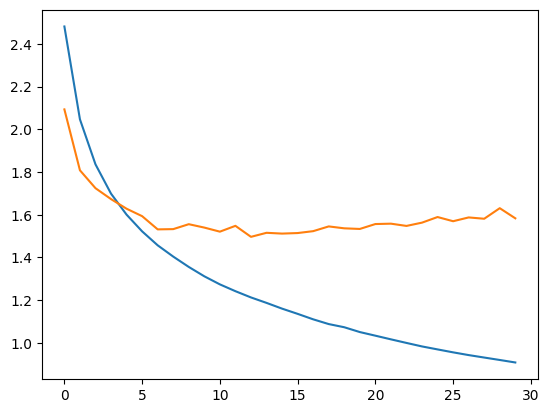

In [82]:
plt.plot(range(EPOCHS), train_losses)
plt.plot(range(EPOCHS), val_losses)

### Evaluate Model on Test Set

In [10]:
torch.backends.mps.is_available()

True